In [1]:
import itertools as itt
import math
from collections import Counter, defaultdict

import bioregistry
import bioversions
import matplotlib.pyplot as plt
import networkx as nx
import pandas as pd
import pyobo
import seaborn as sns
from disease import CONFIGURATION, MODULE
from IPython.display import SVG
from pyobo.sources.mesh import get_mesh_category_curies
from tqdm.auto import tqdm

import semra
import semra.api
from semra.api import to_multidigraph
from semra.io import from_pickle, from_sssom
from semra.analysis.landscape import draw_counter, counter_to_df, landscape_analysis, get_directed_index
import matplotlib.pyplot as plt
from matplotlib_inline.backend_inline import set_matplotlib_formats

/Users/cthoyt/.virtualenvs/indra/lib/python3.11/site-packages/pydantic/_internal/_config.py:322: UserWarning: Valid config keys have changed in V2:
* 'underscore_attrs_are_private' has been removed
  warnings.warn(message, UserWarning)


In [2]:
set_matplotlib_formats('svg')

## Summarize the Resources

In [3]:
# some resources are generic, so we want to cut to a relevant subset
subsets = {
    "mesh": [*get_mesh_category_curies("C"), *get_mesh_category_curies("F")],
    "efo": ["efo:0000408"],
    "ncit": ["ncit:C2991"],
}

terms = {}
for prefix in CONFIGURATION.priority:
    id_name_mapping = pyobo.get_id_name_mapping(prefix)
    subset = {
        descendant
        for parent_curie in subsets.get(prefix, [])
        for descendant in pyobo.get_descendants(parent_curie) or []
    }
    if subset:
        terms[prefix] = {k: v for k, v in id_name_mapping.items() if f"{prefix}:{k}" in subset}
    else:
        terms[prefix] = id_name_mapping

In [4]:
no_versions = {"icd9", "icd10cm", "icd10pcs", "icd9cm", "icdo", "gard", "omim", "orphanet", "omim.ps"}
summary_rows = [
    (
        prefix,
        bioregistry.get_license(prefix),
        bioversions.get_version(prefix) if prefix not in no_versions else None,
        len(terms.get(prefix, [])),
    )
    for prefix in CONFIGURATION.priority
]
summary_df = pd.DataFrame(summary_rows, columns=["prefix", "license", "version", "terms"])
summary_df

,prefix,license,version,terms
0,doid,CC0-1.0,2024-02-28,11511
1,mondo,CC-BY-4.0,2024-03-04,24099
2,efo,Apache-2.0,3.64.0,2082
3,mesh,CC0-1.0,2024,3120
4,ncit,CC-BY-4.0,24.02d,20094
5,orphanet,None,None,0
6,orphanet.ordo,CC-BY-4.0,4.4,0
7,omim,None,None,0
8,omim.ps,None,None,0
9,gard,None,None,0


## Summarize the Mappings

In [5]:
mappings = from_pickle(MODULE.join(name="processed.pkl"))
processed_n = len(mappings)
processed_n

413647

In [6]:
directed = get_directed_index(mappings)

### Asymmetric Summarization

The following summary looks for each ordered pair of resources, what percentage of each resources' terms are mapped to the other resource. Because each resource is a different size, this is an asymmetric measurement.

The way to read this table is the horizontal index corresponds to the source prefix and the columns correspond to the target prefix. This means in the row with label "efo" and column with label "mesh" that has 14% means that 14% of EFO can be mapped to MeSH.

In [7]:
asymmetric_counts = {}
for (l, r), l_entities in directed.items():
    l_terms = terms.get(l)
    if l_terms:
        count = len(l_entities.intersection(l_terms))
    else:
        count = len(l_entities)
    asymmetric_counts[l, r] = count

asymmetric_counts_summary_df = counter_to_df(asymmetric_counts, priority=CONFIGURATION.priority, default=0).fillna(0).astype(int)
asymmetric_counts_summary_df

target_prefix,doid,mondo,efo,mesh,ncit,orphanet.ordo,omim,omim.ps,gard,icd10,icd10cm,icd9cm,icdo
source_prefix,,,,,,,,,,,,,
doid,0,11196,2278,1863,4963,2508,185,81,30,11,127,5,1
mondo,11365,0,3248,8159,7460,8156,9486,575,2,15,1141,2,0
efo,1266,1656,0,1178,1280,219,117,26,0,9,296,0,0
mesh,262,853,587,0,462,138,19,2,0,3,215,0,0
ncit,5094,7145,2375,1585,0,585,217,52,2,9,529,1,0
orphanet.ordo,2489,9545,387,612,572,0,33,71,1,0,193,1,0
omim,191,9744,216,1288,208,32,0,4,2,1,49,1,0
omim.ps,78,577,45,47,50,64,4,0,1,0,19,1,0
gard,30,2,0,1,2,1,2,1,0,0,1,1,0


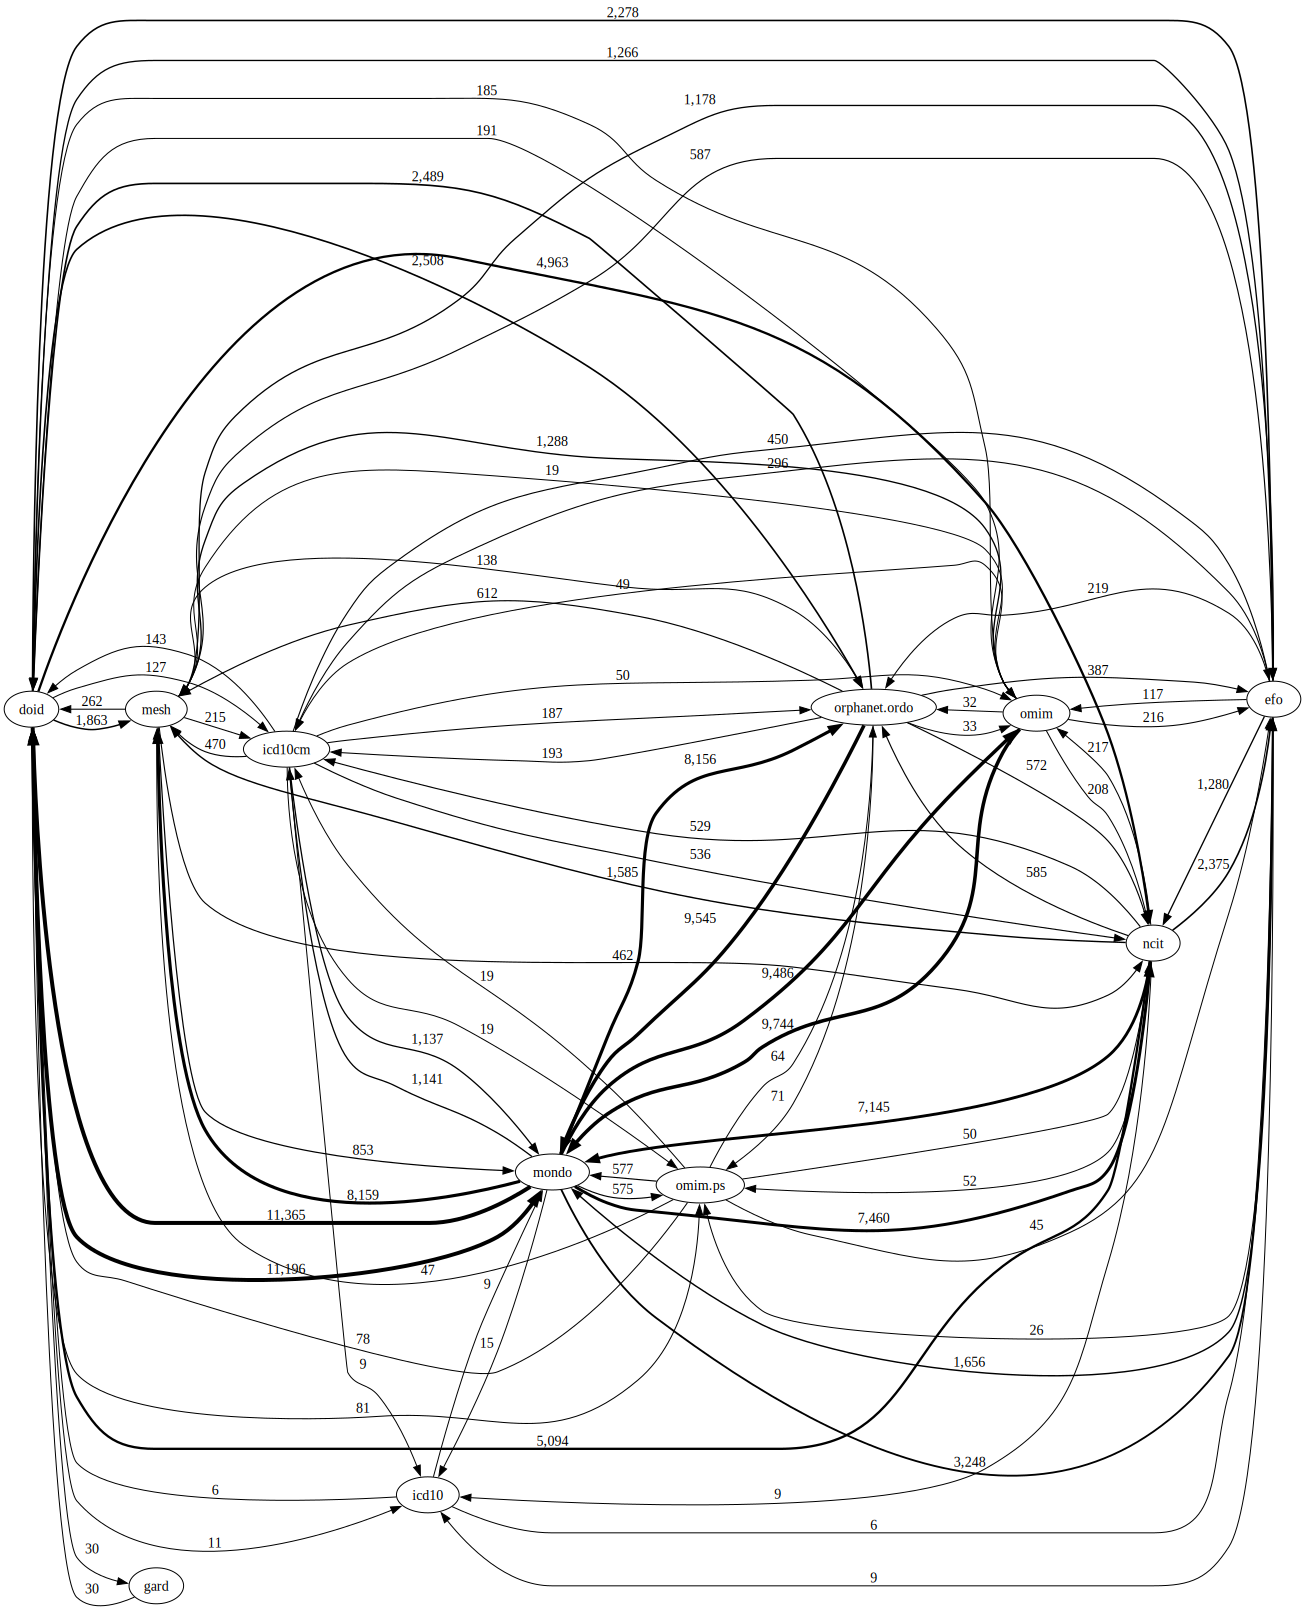

In [8]:
SVG(draw_counter(asymmetric_counts, minimum_count=5))

In [9]:
asymmetric = {}
for (l, r), count in asymmetric_counts.items():
    denominator = len(terms.get(l, []))
    asymmetric[l, r] = count / denominator if denominator > 0 else None

asymmetric_summary_df = counter_to_df(asymmetric, priority=CONFIGURATION.priority)
(asymmetric_summary_df * 100).round(2)

target_prefix,doid,mondo,efo,mesh,ncit,orphanet.ordo,omim,omim.ps,gard,icd10,icd10cm,icd9cm,icdo
source_prefix,,,,,,,,,,,,,
doid,NaN,97.26,19.79,16.18,43.12,21.79,1.61,0.70,0.26,0.10,1.10,0.04,0.01
mondo,47.16,NaN,13.48,33.86,30.96,33.84,39.36,2.39,0.01,0.06,4.73,0.01,NaN
efo,60.81,79.54,NaN,56.58,61.48,10.52,5.62,1.25,NaN,0.43,14.22,NaN,NaN
mesh,8.40,27.34,18.81,NaN,14.81,4.42,0.61,0.06,0.00,0.10,6.89,0.00,NaN
ncit,25.35,35.56,11.82,7.89,NaN,2.91,1.08,0.26,0.01,0.04,2.63,0.00,NaN
icd10,0.26,0.38,0.26,0.21,0.21,NaN,0.04,NaN,NaN,NaN,0.17,NaN,NaN


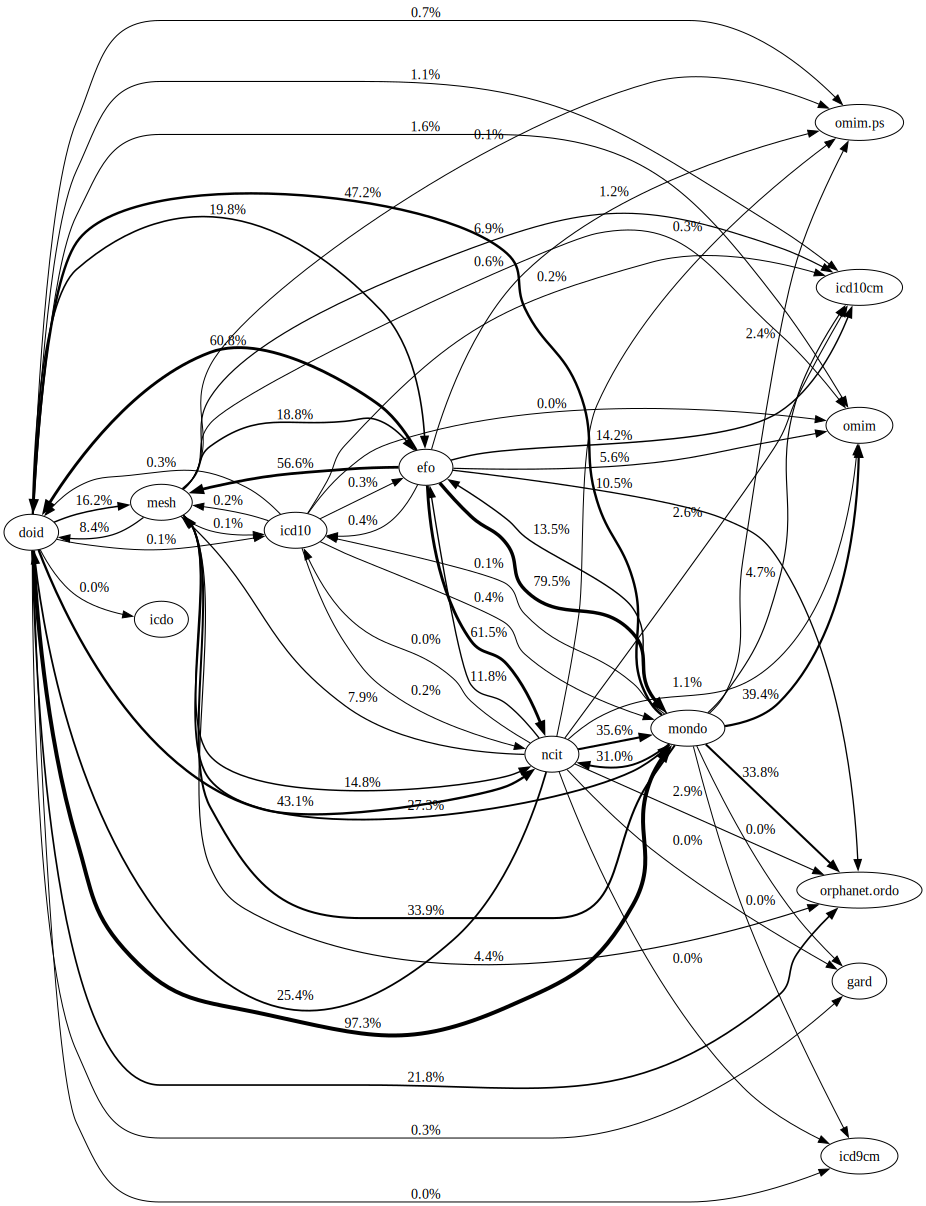

In [10]:
SVG(draw_counter(asymmetric, count_format=".1%"))

### Symmetric Summarization

In [22]:
symmetric_counts = {}
for l, r in directed:
    left = directed[l, r]
    if left_terms := terms.get(l, []):
        left.intersection_update(left_terms)
    right = directed[r, l]
    if right_terms := terms.get(r, []):
        right.intersection_update(right_terms)
    symmetric_counts[l, r] = max(len(left), len(right))

symmetric_counts_df = counter_to_df(symmetric_counts, priority=CONFIGURATION.priority, default=0).fillna(0).astype(int)
symmetric_counts_df.to_csv("counts.tsv", sep='\t', index=True)
symmetric_counts_df

target_prefix,doid,mondo,efo,mesh,ncit,orphanet.ordo,omim,omim.ps,gard,icd10,icd10cm,icd9cm,icdo
source_prefix,,,,,,,,,,,,,
doid,0,11365,2278,1863,5094,2508,191,81,30,11,143,5,1
mondo,11365,0,3248,8159,7460,9545,9744,577,2,15,1141,2,0
efo,2278,3248,0,1178,2375,387,216,45,0,9,450,0,0
mesh,1863,8159,1178,0,1585,612,1288,47,1,5,470,1,0
ncit,5094,7460,2375,1585,0,585,217,52,2,9,536,1,0
orphanet.ordo,2508,9545,387,612,585,0,33,71,1,0,193,1,0
omim,191,9744,216,1288,217,33,0,4,2,1,50,1,0
omim.ps,81,577,45,47,52,71,4,0,1,0,19,1,0
gard,30,2,0,1,2,1,2,1,0,0,1,1,0


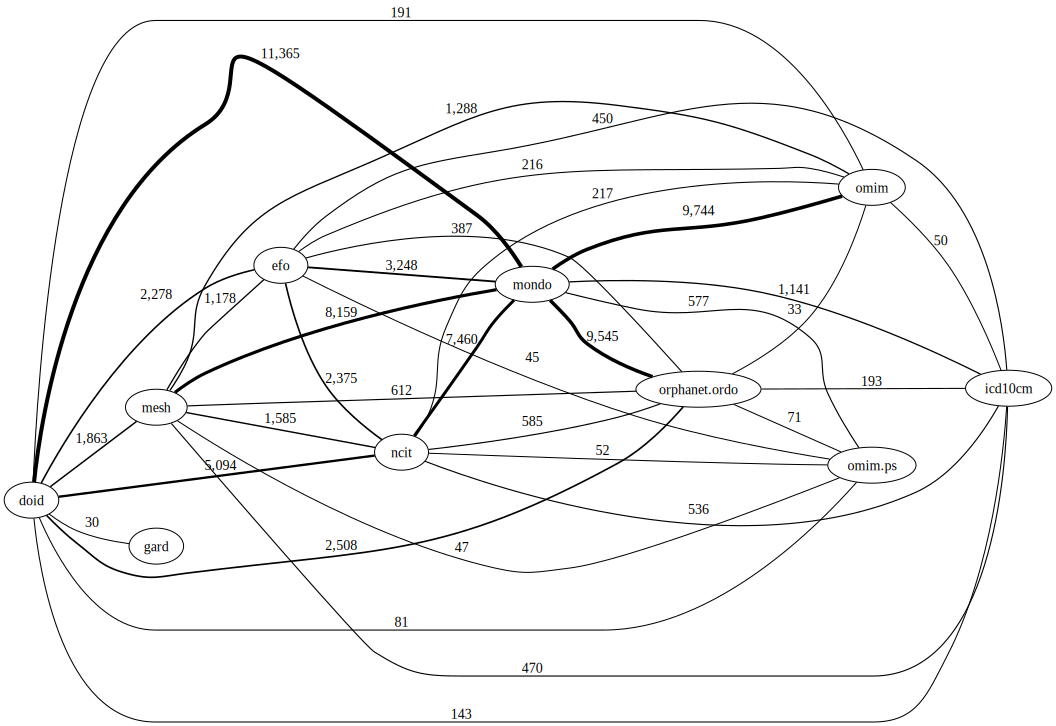

In [12]:
x = draw_counter(symmetric_counts, cls=nx.Graph, minimum_count=20)
with open("disease_graph.svg", "wb") as file:
    file.write(x)
SVG(x)

In [20]:
# intersect with the terms for each to make sure we're not keeping any mappings that are irrelevant

symmetric = {}
for (l, r), count in symmetric_counts.items():
    # FIXME - estimate terms lists based on what appears in the mappings
    if terms[r] and terms[l]:
        denom = max(len(terms[r]), len(terms[l]))
    elif terms[r]:
        denom = len(terms[r])
    elif terms[l]:
        denom = len(terms[l])
    else:
        denom = None  
        continue
    symmetric[l, r] = count / denom

symmetric_df = counter_to_df(symmetric, priority=CONFIGURATION.priority).fillna(0.0)

# clip since there might be some artifacts of mappings to terms that don't exist anymore
(symmetric_df * 100).round(3)

target_prefix,doid,mondo,efo,mesh,ncit,orphanet.ordo,omim,omim.ps,gard,icd10,icd10cm,icd9cm,icdo
source_prefix,,,,,,,,,,,,,
doid,0.000,47.160,19.790,16.185,25.351,21.788,1.659,0.704,0.261,0.096,1.242,0.043,0.009
mondo,47.160,0.000,13.478,33.856,30.956,39.607,40.433,2.394,0.008,0.062,4.735,0.008,0.000
efo,19.790,13.478,0.000,37.756,11.819,18.588,10.375,2.161,0.000,0.384,21.614,0.000,0.000
mesh,16.185,33.856,37.756,0.000,7.888,19.615,41.282,1.506,0.032,0.160,15.064,0.032,0.000
ncit,25.351,30.956,11.819,7.888,0.000,2.911,1.080,0.259,0.010,0.045,2.667,0.005,0.000
orphanet.ordo,21.788,39.607,18.588,19.615,2.911,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000
omim,1.659,40.433,10.375,41.282,1.080,0.000,0.000,0.000,0.000,0.043,0.000,0.000,0.000
omim.ps,0.704,2.394,2.161,1.506,0.259,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000
gard,0.261,0.008,0.000,0.032,0.010,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000


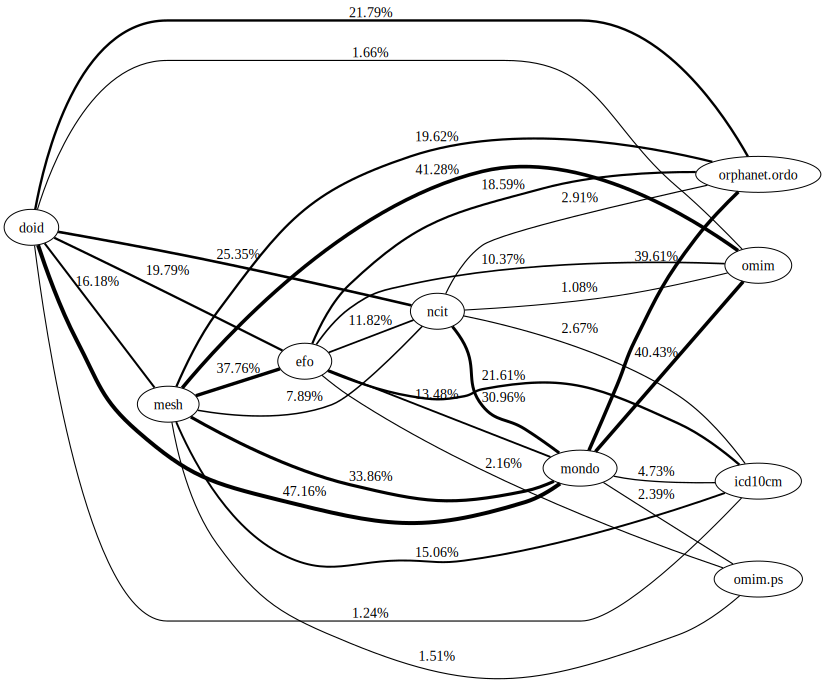

In [21]:
SVG(draw_counter(symmetric, cls=nx.Graph, count_format=".2%", minimum_count=0.01))

# Landscape Coverage

Before, we looked at the overlaps between each resource. Now, we use that information jointly to estimate the number of terms in the landscape itself, and estimate how much of the landscape each resource covers.

In [15]:
landscape_results = landscape_analysis(
    mappings, terms=terms, priority=CONFIGURATION.priority
)

print(landscape_results.describe())

This estimates a total of 105,505 unique entities.
Of these, 16,866 (16.0%) have at least one mapping.
88,639 (84.0%) are unique to a single resource.
0 (0.0%) appear in all 17 resources.

This estimate is susceptible to several caveats:

- Missing mappings inflates this measurement
- Generic resources like MeSH contain irrelevant entities that can't be mapped



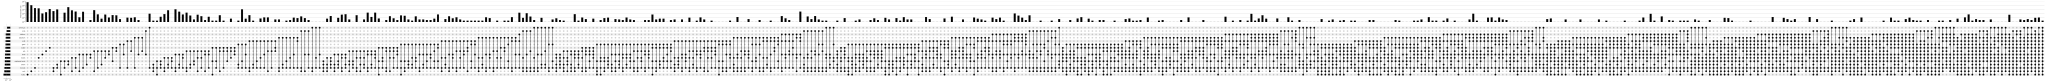

In [16]:
landscape_results.plot_upset()

plt.savefig("disease_upset.svg")
plt.show()

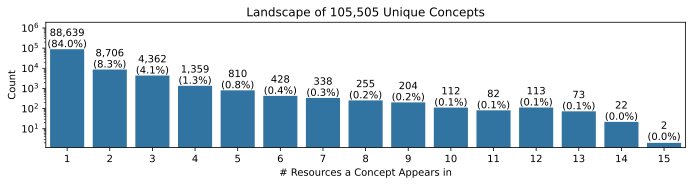

In [17]:
landscape_results.plot_distribution()

plt.tight_layout()
plt.savefig("disease_histogram.svg")
plt.show()